# **BCG X Capstone Project**
<img src="https://web-assets.bcg.com/1a/1f/6b52570e4ba49920815bdda88e36/bcgx-meet-banner.jpg" alt="drawing" style="width:800px; height:300px"/>

### **Churn Modelling - Creating our Churn Model Notebook**

**Group members**

Morten Aas-Lyngby, Paolo Brambillasca,  Ignacio Alonso Lopez-Linares, Emilio Jair Rodriguez Capitan, Alberto Dona



**Notebook description**

This notebook provides the second step in our Analysis. We will develop a churn model for preventing clients from leaving ClientCo.

**Problem definition**

The Team has been tasked with building a Churn Model to increase CLTV as well as to help ClienCo. in their product cross-selling strategy and demand forecasting problem.

# Table of Contents

1. [Import the Necessary Libraries](#import-the-necessary-libraries)
2. [Defining Churn](#defining-churn)
   - 2.1 [Chosen Churn Definition - Recency, Max Purchase Lag and Median Avg between purchases](#chosen-churn-definition)
   - 2.2 [2nd Churn Definition - not chosen](#2nd-churn-definition)
   - 2.3 [3rd Churn Definition - not chosen](#3rd-churn-definition)
3. [Creating a Churn Model](#creating-a-churn-model)
   - 3.1 [Loading the data](#loading-the-data)
   - 3.2 [Preliminary Correlation Matrix](#preliminary-correlation-matrix)
   - 3.3 [Preparing the data](#preparing-the-data)
     - 3.3.1 [Division of the dataset in train and test](#division-of-the-dataset-in-train-and-test)
     - 3.3.2 [Scale the data](#scale-the-data)
   - 3.4 [Modelling](#modelling)
     - 3.4.1 [Initial Model - A lot of Data leakage](#initial-model)
     - 3.4.2 [Second Model - Dropping Recency due to Data Leakage](#second-model)
     - 3.4.3 [Final Model - More Features dropped, Pipeline, Optuna Optimization](#final-model)
   - 3.5 [Final Model Evaluation](#final-model-evaluation)
     - 3.5.1 [Overarching Evaluation](#overarching-evaluation)
     - 3.5.2 [Evaluation on the Customer Segments](#evaluation-on-the-customer-segments)
4. [Identifying priorities](#identifying-priorities)


### **1. Import the Necessary Libraries** 

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, balanced_accuracy_score, matthews_corrcoef,average_precision_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import optuna
import pyarrow
import fastparquet
import matplotlib.pyplot as plt
from scipy.stats import expon, kstest



### **2. Defining Churn**

#### 2.1 Chosen Churn Definition - Recency, Max Purchase Lag and Median Avg between purchases

In [ ]:
df=pd.read_parquet('data/clients_cleaned')

# Criterion 1: Recency-based churn using max_days_between_orders
df['churn_recency_max'] = ((df['recency'] > (df['max_days_between_orders']+df['median_days_between_orders'])) & (df['num_tickets'] > 1)).astype(int)

# Criterion 2: Single order up until the date threshold
df['single_order_churn'] = ((df['num_tickets'] == 1) & (df['recency'] >365)).astype(int)

# Combine the criteria to define churn
df['churn_max'] = ((df['churn_recency_max'] == 1) | (df['single_order_churn'] == 1)).astype(int)

# Check how many clients are marked as churned
num_churned_clients = df['churn_max'].sum()
print(f"Number of clients marked as churned: {num_churned_clients}")

Number of clients marked as churned: 51842


we check the distribution of avg days between orders and later check which distribution best fits this distribution between poisson and exponential.

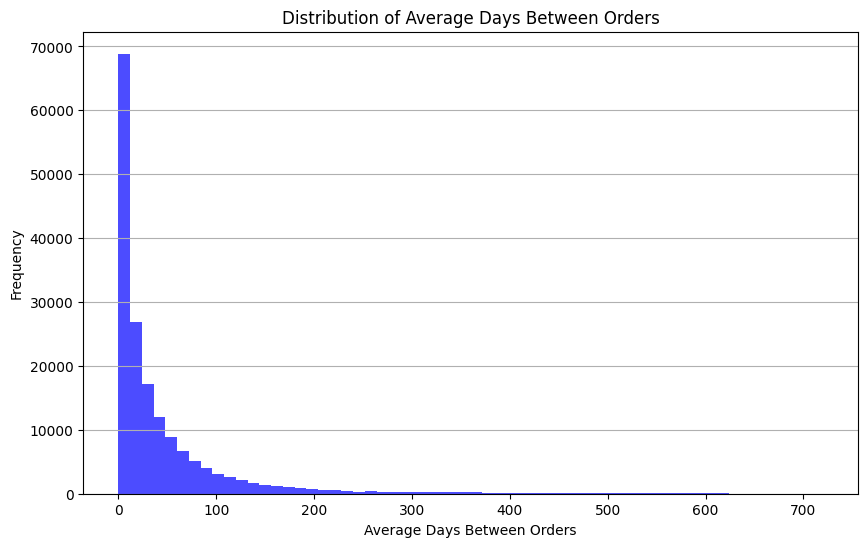

In [ ]:

# Plot the distribution of average days between orders
plt.figure(figsize=(10, 6))
plt.hist(df['avg_days_between_orders'].dropna(), bins=60, color='blue', alpha=0.7)
plt.title('Distribution of Average Days Between Orders')
plt.xlabel('Average Days Between Orders')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

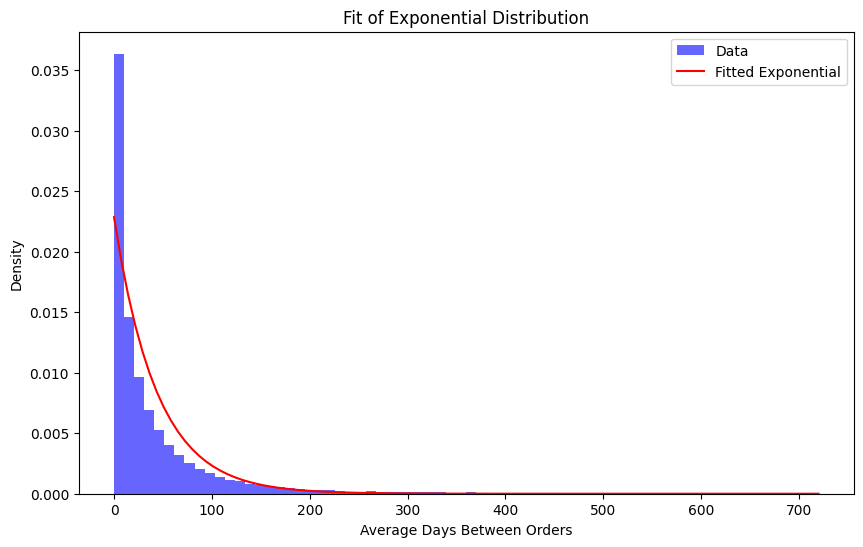

KS statistic: 0.16542701797945697, p-value: 0.0
The exponential distribution is not a good fit for the data (p < 0.05).


In [ ]:

data = df['avg_days_between_orders'].dropna()

# Fit the exponential distribution
loc, scale = expon.fit(data, floc=0)  # floc=0 fixes the location to zero

# Plot histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(data, bins=70, density=True, alpha=0.6, color='blue', label='Data')

# Plot the fitted exponential distribution
x = np.linspace(0, data.max(), 100)
pdf_fitted = expon.pdf(x, loc, scale)
plt.plot(x, pdf_fitted, 'r-', label='Fitted Exponential')

plt.title('Fit of Exponential Distribution')
plt.xlabel('Average Days Between Orders')
plt.ylabel('Density')
plt.legend()
plt.show()

# Kolmogorov-Smirnov test for goodness of fit
ks_stat, p_value = kstest(data, 'expon', args=(loc, scale))
print(f"KS statistic: {ks_stat}, p-value: {p_value}")

if p_value < 0.05:
    print("The exponential distribution is not a good fit for the data (p < 0.05).")
else:
    print("The exponential distribution is a good fit for the data (p >= 0.05).")

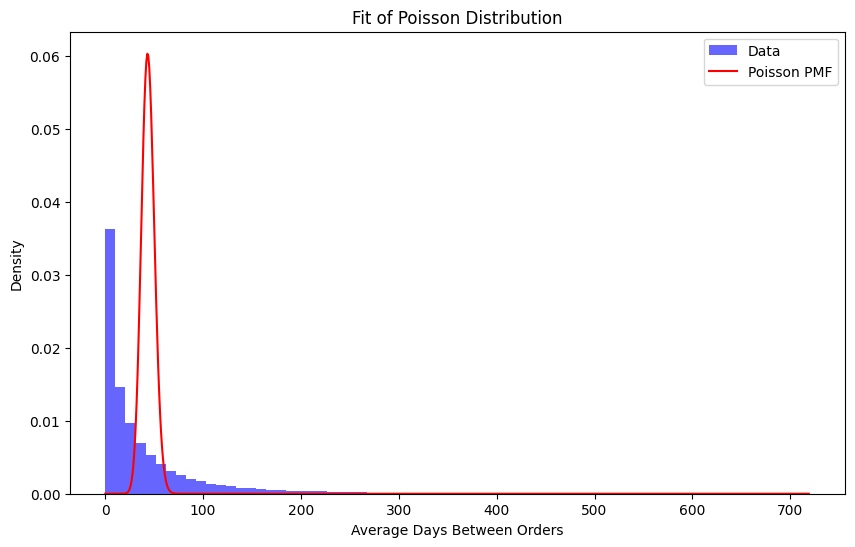

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, kstest

# Assuming 'df' has a column 'avg_days_between_orders'
data = df['avg_days_between_orders'].dropna()

# Calculate lambda (mean) for Poisson distribution
lambda_poisson = data.mean()

# Plot histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(data, bins=70, density=True, alpha=0.6, color='blue', label='Data')

# Plot the Poisson PMF
x = np.arange(0, data.max())
poisson_pmf = poisson.pmf(x, lambda_poisson)
plt.plot(x, poisson_pmf, 'r-', label='Poisson PMF')

plt.title('Fit of Poisson Distribution')
plt.xlabel('Average Days Between Orders')
plt.ylabel('Density')
plt.legend()
plt.show()

# Note: Poisson is usually used for count data; this fit may not be ideal for continuous days

#### 2.2 2nd Churn Definition - not chosen

Based on Poisson 99th percentile of avg days between orders

In [ ]:
#from scipy.stats import poisson

# Define the date threshold (assuming this was part of the business logic)
#date_threshold = pd.to_datetime('2018-09-22')

# Criterion 1: Recency-based churn using Poisson distribution
# We assume that 'avg_days_between_orders' is the lambda (mean rate of events) for the Poisson distribution
#df['churn_recency_poisson'] = df.apply(lambda row: poisson.cdf(row['recency'], row['avg_days_between_orders']) < 0.01, axis=1).astype(int)

# Combine the criteria to define churn
#df['churn_poi'] = ((df['churn_recency_poisson'] == 1) | (df['single_order_churn'] == 1)).astype(int)

# Check how many clients are marked as churned
#num_churned_clients = df['churn_poi'].sum()
#print(f"Number of clients marked as churned: {num_churned_clients}")

#### 2.2 3rd Churn Definition - not chosen


Based on Exponential 99th percentile of avg days between orders

In [ ]:
#from scipy.stats import expon

# Fit the exponential distribution to avg_days_between_orders
#loc, scale = expon.fit(df['avg_days_between_orders'], floc=0)  # floc=0 fixes the location to zero

# Calculate the 99th percentile for the exponential distribution
#threshold_99 = expon.ppf(0.99, loc=loc, scale=scale)

# Define churn based on recency exceeding the 99th percentile and single order churn
#df['churn_recency_exponential'] = (df['recency'] > threshold_99).astype(int)
#df['churn_exponential'] = ((df['churn_recency_exponential'] == 1) | (df['single_order_churn'] == 1)).astype(int)

# Check how many clients are marked as churned
#num_churned_clients = df['churn_exponential'].sum()
#print(f"Number of clients marked as churned: {num_churned_clients}")

#df=df.drop(columns=['churn_recency_max','single_order_churn'])

### **3. Creating a Churn Model**

#### 3.1 Loading the data

In [ ]:
data = pd.read_parquet('data/Final_grouped_with_churn')

In [ ]:
data.head()

,client_id,first_order_date,last_order_date,total_sales,total_quantity,num_tickets,num_negative_tickets,sum_negative_sales,sum_positive_sales,unique_branches,...,monthly_frequency,avg_sale_value,refunds_per_ticket,refunds_percentage,avg_ticket_quantity,sales_total_with_respect_to_total_sales,median_days_between_orders,churn_recency_max,single_order_churn,churn_max
0,6,2017-10-27,2019-08-13,5.882233e+03,3038,40,0,0.000000,5.882233e+03,1,...,1.832061,147.055817,0.000000,0.000000,75.949997,6.416573e-07,0.0,0,0,0
1,7,2018-07-16,2018-12-24,1.190777e+03,99,15,0,0.000000,1.190777e+03,1,...,2.795031,79.385139,0.000000,0.000000,6.600000,1.298947e-07,0.0,1,0,1
2,14,2017-09-25,2019-09-20,3.043896e+06,1362031,12339,73,-51743.144531,3.095638e+06,9,...,510.579315,246.689011,0.005916,-0.016715,110.384232,3.320402e-04,0.0,0,0,0
3,18,2017-09-26,2019-09-12,2.180872e+05,72186,2194,147,-25992.683594,2.440798e+05,2,...,91.927376,99.401619,0.067001,-0.106493,32.901550,2.378981e-05,0.0,0,0,0
4,25,2018-10-10,2018-10-10,3.745861e+02,108,4,0,0.000000,3.745861e+02,1,...,inf,93.646530,0.000000,0.000000,27.000000,4.086134e-08,0.0,1,0,1


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 25 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   client_id                                170589 non-null  int32         
 1   first_order_date                         170589 non-null  datetime64[ns]
 2   last_order_date                          170589 non-null  datetime64[ns]
 3   total_sales                              170589 non-null  float32       
 4   total_quantity                           170589 non-null  int32         
 5   num_tickets                              170589 non-null  int32         
 6   num_negative_tickets                     170589 non-null  int32         
 7   sum_negative_sales                       170589 non-null  float32       
 8   sum_positive_sales                       170589 non-null  float32       
 9   unique_branches           

In [ ]:
# Splitting the data
X = data.drop(columns=['churn_max', 'single_order_churn',"churn_recency_max","first_order_date","last_order_date","client_id"], axis=1)
y = data['churn_max']



In [ ]:
# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN values with the column mean
X.fillna(X.median(), inplace=True)

# Optionally, ensure all columns are of type float64
X = X.astype(np.float64)


#### 3.2 Preliminary Correlation Matrix

Let's analyze the correlation between the variables to get rid of the highly correlated ones

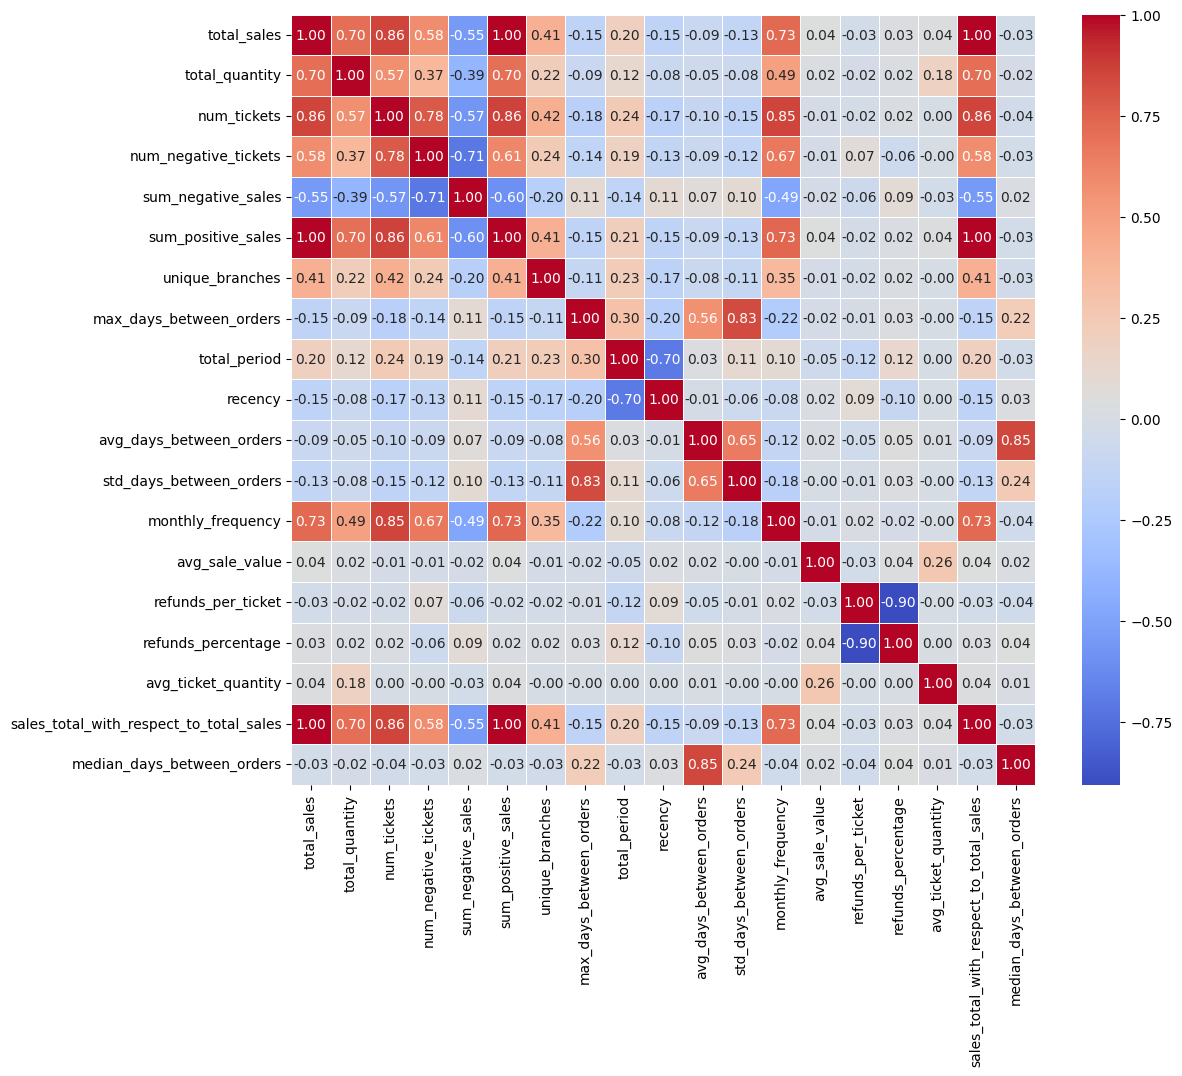

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the correlation matrix
correlation_matrix = X.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

# Show the plot
plt.show()


In [ ]:
# Dropping highly correlated variables according the previous correlated matrix
X = X.drop(columns=["num_negative_tickets","sum_positive_sales","monthly_frequency","refunds_per_ticket","sales_total_with_respect_to_total_sales","median_days_between_orders"],axis=1)


#### 3.3 Preparing the data

##### 3.3.1 Division of the dataset in train and test.


Train will be 70% of the original data and test 30%.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( ##it gives back 4 arrays
    X, y,               # Arrays or matrices I want to split
    test_size=0.3,      # The proportion to data for testing
    random_state=123,   # Make the split reproducibile
    shuffle=True,       # If we want to shuffle data before splitting (this is good if we are not using time series)
    stratify=y          # For clasification problems. Split data stratifying the target variable (When the data is not balanced)
)

# Display the sizes of the training and testing sets
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Training set size:", y_train.shape)
print("Testing set size:", y_test.shape)


Training set size: (119412, 13)
Testing set size: (51177, 13)
Training set size: (119412,)
Testing set size: (51177,)


##### 3.3.2 Scale the data


In [ ]:
# Initialize the RobustScaler. We will use this kind of scaler since we are dealing with an unbalanced dataset
Rscaler = RobustScaler()

Rscaler.fit(X_train)
x_train_sc = Rscaler.transform(X_train)
x_test_sc = Rscaler.transform(X_test)


#### 3.4 Modelling

##### 3.4.1 Initial Model - A lot of Data leakage


In [ ]:
# Choose Ranfom Forest as a first model
rf = RandomForestClassifier()
rf.fit(x_train_sc, y_train)
y_pred = rf.predict(x_test_sc)

# Let's see all the different scores for the trainig part

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred, average='binary') # Use 'micro', 'macro', or 'weighted' for multi-class
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred, average='binary') # Use 'micro', 'macro', or 'weighted' for multi-class
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred, average='binary') # Use 'micro', 'macro', or 'weighted' for multi-class
print("F1 Score:", f1)


Accuracy: 0.9946851124528597
Precision: 0.9943707277844793
Recall: 0.9900486130969403
F1 Score: 0.992204963604058


Since we are dealing with an unbalanced dataset, the best evaluation metric for this case is the F1 score. In this part of the analysis, we can see we have the perfect model with a very high F1 of 99,13. This is because the model has learned everything about how we labeled the churn in the original dataset. Below, we will see the feature importance.

In [ ]:
# Get feature importances
feature_importances = rf.feature_importances_

# Assuming you have a list of feature names that matches the columns in your X data
feature_names = X.columns

# Create a pandas series to visualize the feature importances
importances = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances in descending order
importances_sorted = importances.sort_values(ascending=False)

# Display the feature importances
print(importances_sorted)


churn_max                  0.542520
recency                    0.203108
total_period               0.095666
num_tickets                0.039181
max_days_between_orders    0.036191
std_days_between_orders    0.027493
avg_days_between_orders    0.022475
total_quantity             0.014826
total_sales                0.008169
unique_branches            0.004480
sum_negative_sales         0.002226
refunds_percentage         0.002171
avg_ticket_quantity        0.000779
avg_sale_value             0.000714
dtype: float64


With the feature importance, we can see the variable that explains the most the predictions of our model is recency, with a 48,55% of contribution. After this, total period and maximum days between orders are the second and third most important variables to explain churn for the model. This confirms that the model learned our method to label churn


##### 3.4.2 Second Model - Dropping Recency due to Data Leakage


To analyze and understand more the model, we decided to delete recency, as this variable contains 48,55% of the information to predict churn and can bias the model. Also, we used this to make our definition of churn.

In [ ]:
X = X.drop(columns=["recency"])


Do the same process of split, scale, train and evaluate.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( ##it gives back 4 arrays
    X, y,               # arrays or matrices I want to split
    test_size=0.3,      # the proportion to data for testing (if its an integer, how many rows do you want from the dataset)
    random_state=123,   # can be any number. make the split reproducibile
    shuffle=True,       # if we want to shuffle data before splitting (this is good if we are not using time series)
    stratify=y       # For clasification problems. Split data stratifying the target variable (for classificatino problem when the data is not balanced)
)

# Display the sizes of the training and testing sets
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Training set size:", y_train.shape)
print("Testing set size:", y_test.shape)


Training set size: (119412, 12)
Testing set size: (51177, 12)
Training set size: (119412,)
Testing set size: (51177,)


In [ ]:
# Initialize the RobustScaler for unbalanced data
Rscaler = RobustScaler()

Rscaler.fit(X_train)
x_train_sc = Rscaler.transform(X_train)
x_test_sc = Rscaler.transform(X_test)


In [ ]:
# Let's run again Random Forest
rf = RandomForestClassifier()

rf.fit(x_train_sc, y_train)

y_pred = rf.predict(x_test_sc)

# Let's see all the different scores for the trainig part

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred, average='binary') # Use 'micro', 'macro', or 'weighted' for multi-class
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred, average='binary') # Use 'micro', 'macro', or 'weighted' for multi-class
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred, average='binary') # Use 'micro', 'macro', or 'weighted' for multi-class
print("F1 Score:", f1)


Accuracy: 0.8516325693182484
Precision: 0.7740773578632384
Recall: 0.7989133543036889
F1 Score: 0.7862992879457376


In [ ]:
# Get feature importances
feature_importances = rf.feature_importances_

# Assuming you have a list of feature names that matches the columns in your X data
feature_names = X.columns

# Create a pandas series to visualize the feature importances
importances = pd.Series(feature_importances, index=feature_names)

# Sort the feature importances in descending order
importances_sorted = importances.sort_values(ascending=False)

# Display the feature importances
print(importances_sorted)


churn_max                  0.495599
recency                    0.231673
total_period               0.106467
max_days_between_orders    0.047289
num_tickets                0.046219
avg_days_between_orders    0.023610
std_days_between_orders    0.016164
total_sales                0.015933
total_quantity             0.011884
refunds_percentage         0.001401
unique_branches            0.001173
sum_negative_sales         0.001033
avg_sale_value             0.000913
avg_ticket_quantity        0.000643
dtype: float64


After we dropped the recency variable, it can be seen that we still have a very good model, with a F1 score of 78,73. This means that the model can predict churn taking into account other variables rather than recency, being the total period explaining 32,03% of the prediction, maximum days between orders a 12,91% and number of tickets 10,23%.

We will try a third model, dropping all the variables that we use to calculate churn in the original dataset, to see if the model is still giving a good evaluation score by only using different variables and preventing to the minimum information leakage.

##### 3.4.3 Final Model - More Features dropped, Pipeline, Optuna Optimization


First we will dropp 3 variables that somehow are related to the approach we used to calculate churn.

In [ ]:
X = X.drop(columns=["max_days_between_orders","std_days_between_orders","avg_days_between_orders"])


Do the same process of split, scale, train and evaluate.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( ##it gives back 4 arrays
    X, y,               # arrays or matrices I want to split
    test_size=0.3,      # the proportion to data for testing (if its an integer, how many rows do you want from the dataset)
    random_state=123,   # can be any number. make the split reproducibile
    shuffle=True,       # if we want to shuffle data before splitting (this is good if we are not using time series)
    stratify=y       # For clasification problems. Split data stratifying the target variable (for classificatino problem when the data is not balanced)
)

# Display the sizes of the training and testing sets
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)
print("Training set size:", y_train.shape)
print("Testing set size:", y_test.shape)


Training set size: (119412, 9)
Testing set size: (51177, 9)
Training set size: (119412,)
Testing set size: (51177,)


In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 10, 200)
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)

    # Define the pipeline
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('classifier', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        ))
    ])

    # Evaluate the model using cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')
    return scores.mean()

# Create the study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print('Best hyperparameters: ', study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        random_state=42
    ))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
f1 = f1_score(y_test, y_pred, average='binary') # Use 'micro', 'macro', or 'weighted' for multi-class
print("F1 Score:", f1)


[I 2024-07-10 12:20:08,024] A new study created in memory with name: no-name-46b830d8-bace-410f-bc39-d3c3acacbc42
[I 2024-07-10 12:20:20,966] Trial 0 finished with value: 0.7776135701788993 and parameters: {'n_estimators': 26, 'max_depth': 16, 'min_samples_split': 16, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7776135701788993.
[I 2024-07-10 12:20:27,913] Trial 1 finished with value: 0.7740189392498693 and parameters: {'n_estimators': 13, 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7776135701788993.
[I 2024-07-10 12:21:55,896] Trial 2 finished with value: 0.779149385409499 and parameters: {'n_estimators': 174, 'max_depth': 29, 'min_samples_split': 11, 'min_samples_leaf': 19}. Best is trial 2 with value: 0.779149385409499.
[I 2024-07-10 12:22:14,451] Trial 3 finished with value: 0.7776323485713302 and parameters: {'n_estimators': 35, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 10}. Best is trial 2 with val

Best hyperparameters:  {'n_estimators': 178, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 9}
F1 Score: 0.7808913948941717


In [ ]:
# Get the feature importances from the trained classifier
feature_names = X.columns
classifier = pipeline.named_steps['classifier']
feature_importances = classifier.feature_importances_

# Ensure the feature names and importances have the same length
assert len(feature_names) == len(feature_importances), "Feature names and importances must have the same length."

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(importance_df)


               Feature  Importance
5         total_period    0.615876
2          num_tickets    0.172842
0          total_sales    0.087314
1       total_quantity    0.058575
6       avg_sale_value    0.017388
4      unique_branches    0.016798
8  avg_ticket_quantity    0.011461
3   sum_negative_sales    0.010334
7   refunds_percentage    0.009412


In [ ]:
# Saving the model
import joblib

model_filename = 'best_model_churn.pkl'
joblib.dump(pipeline, model_filename)

#### 3.5 Final Model Evaluation


##### 3.5.1 Overarching Evaluation

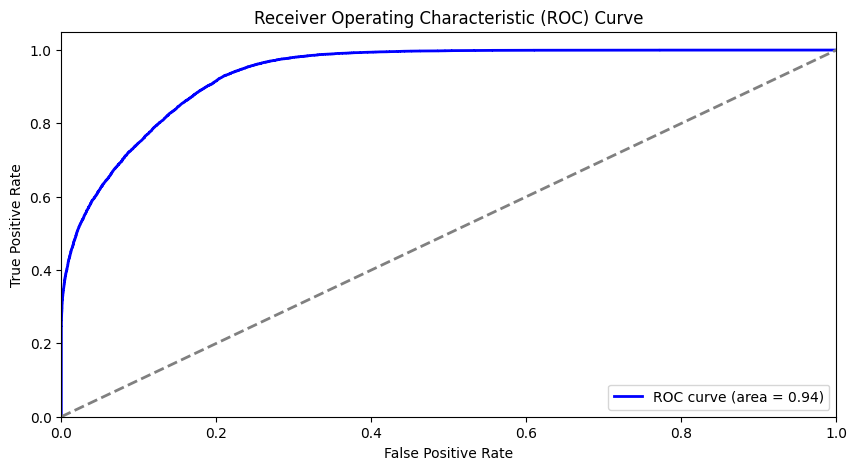

In [ ]:
# Compute probability scores for the ROC AUC curve
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC AUC curve
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


This model is very good trying to predict churn, taking into consideration different variables than the ones used to define it. With an F1 score of 76,99, it takes into consideration the total period a customer has been buying with the company as the most valuable variable, followed by number of tickets and total sales. This variables take into consideration both time and sales to try to predict churn.

In [ ]:
y_train


15028     1
56276     1
64858     0
94320     1
112356    1
         ..
107192    1
38599     1
82188     1
135517    1
121813    1
Name: churn_max, Length: 119412, dtype: int64

In [ ]:
# Ensure X_test has the same indices as the original dataset
X_test_indices = X_test.index
X_test_indices

# Create a DataFrame with y_proba and the corresponding indices
y_proba_df = pd.DataFrame(y_proba, index=X_test_indices, columns=['y_proba'])

# Merge the y_proba_df with the original dataset
data_with_proba = X_test.join(y_proba_df, how='left', rsuffix='_proba')

data_with_proba.head()


,total_sales,total_quantity,num_tickets,sum_negative_sales,unique_branches,total_period,avg_sale_value,refunds_percentage,avg_ticket_quantity,y_proba
132011,7038.892578,522.0,44.0,-176.545700,7.0,562.0,159.974838,-0.024468,11.863636,0.103634
64841,1481.109375,4885.0,25.0,-2716.535156,1.0,119.0,59.244373,-0.647157,195.399994,0.811598
162796,61381.652344,60553.0,289.0,-2855.271240,1.0,640.0,212.393265,-0.044449,209.525955,0.135473
10757,565.491821,23.0,5.0,0.000000,1.0,0.0,113.098366,0.000000,4.600000,0.985787
68352,37.729198,3.0,1.0,0.000000,1.0,0.0,37.729198,0.000000,3.000000,0.520686


The histogram of predicted probabilities shows the distribution of probabilities assigned by the Random Forest classifier to each class (Class 0 and Class 1, defined as not churn and churn, respectively) in the test dataset.

In [ ]:
# Compute probability scores for the ROC AUC curve
y_prob = pipeline.predict_proba(X_test)[:, 1]


Predicted probabilities shape: (51177, 2)


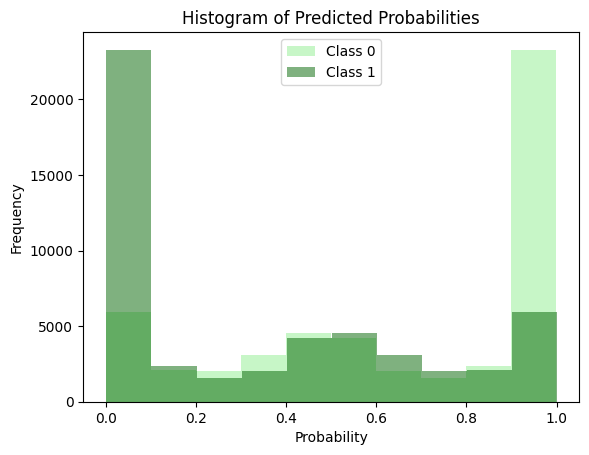

In [ ]:
# Print the shape of predicted probabilities
print("Predicted probabilities shape:", y_prob.shape)

# Extract predicted probabilities for each class
class_0_probs = y_prob[:, 0]
class_1_probs = y_prob[:, 1]

# Plot histograms of the predicted probabilities for each class
plt.hist(class_0_probs, bins=10, alpha=0.5, color='lightgreen', label='Class 0')
plt.hist(class_1_probs, bins=10, alpha=0.5, color='darkgreen', label='Class 1')

plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Predicted Probabilities')
plt.show()



The high peaks at 0 and 1 indicate that the Random Forest model is very confident in its predictions. For many instances, it predicts either a very high probability of being Class 0 (near 1) or a very high probability of being Class 1 (near 0).
This means that the classifier is quite decisive for a large portion of the data, predicting these instances with high certainty.


The low frequencies in the middle range (0.2 to 0.8) suggest that there are few instances where the model is uncertain (i.e., assigning a moderate probability to either class).
This indicates that the model seldom predicts probabilities that reflect uncertainty about the class.


The Random Forest classifier is generally confident in its predictions, assigning most instances to one of the classes with high certainty.

Let's analyze the confurion matrix

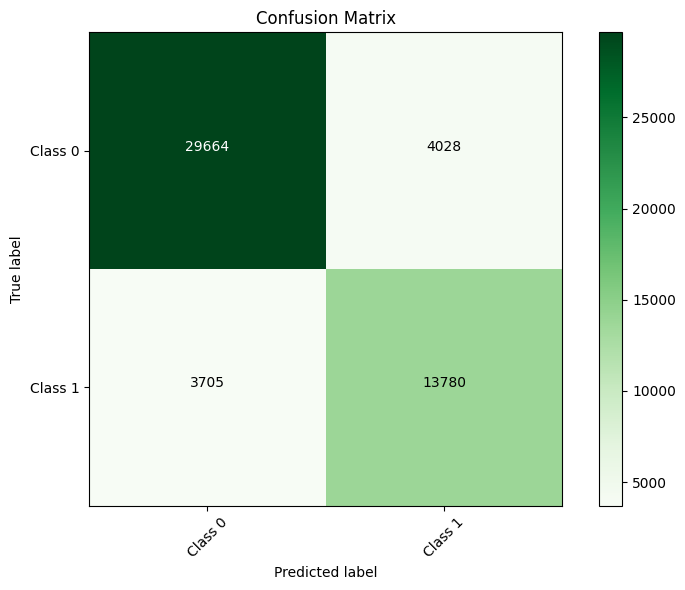

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix with a green color scale
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Greens')
plt.title("Confusion Matrix")
plt.colorbar()

# Add labels to the plot
classes = ['Class 0', 'Class 1'] # Change these to your actual class names if different
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Add the counts to the plot
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()



##### 3.5.2 Evaluation on the Customer Segments


Evaluation the model on the different segments is key to understanding the weaknesses and the strenghts of the model.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BCG/datasets/predicted_with_cluster.csv')
data.info()

In [ ]:
data = data[['client_id', 'total_period', 'num_tickets', 'total_sales', 'total_quantity', 'avg_sale_value', 'avg_ticket_quantity', 'refunds_percentage', 'sum_negative_sales', 'unique_branches', 'churn_max', 'churn_proba', 'churn_proba_monetary', 'Customer_segment', 'CLV']]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             170589 non-null  int64  
 1   total_period          170589 non-null  int64  
 2   num_tickets           170589 non-null  int64  
 3   total_sales           170589 non-null  float64
 4   total_quantity        170589 non-null  int64  
 5   avg_sale_value        170589 non-null  float64
 6   avg_ticket_quantity   170589 non-null  float64
 7   refunds_percentage    170589 non-null  float64
 8   sum_negative_sales    170589 non-null  float64
 9   unique_branches       170589 non-null  int64  
 10  churn_max             170589 non-null  int64  
 11  churn_proba           170589 non-null  float64
 12  churn_proba_monetary  170589 non-null  float64
 13  Customer_segment      170586 non-null  object 
 14  CLV                   170586 non-null  float64
dtype

In [ ]:
data['pred'] = data['churn_proba'].apply(lambda x: 1 if x > 0.5 else 0)

data['true_positive'] = np.where((data['pred'] == 1) & (data['churn_max'] == 1), 1, 0)
data['false_negative'] = np.where((data['pred'] == 1) & (data['churn_max'] == 0), 1, 0)
data['true_negative'] = np.where((data['pred'] == 0) & (data['churn_max'] == 0), 1, 0)
data['false_positive'] = np.where((data['pred'] == 0) & (data['churn_max'] == 1), 1, 0)

In [ ]:
sort_order = {
    'Top Customers': 1,
    'High value Customer': 2,
    'Medium Value Customer': 3,
    'Low Value Customers': 4,
    'Lost Customers': 5
}

groups = data.groupby('Customer_segment').agg({
    'client_id': 'count',
    'total_period': 'mean',
    'num_tickets': 'mean',
    'total_sales': 'mean',
    'total_quantity': 'mean',
    'avg_sale_value': 'mean',
    'avg_ticket_quantity': 'mean',
    'refunds_percentage': 'mean',
    'sum_negative_sales': 'mean',
    'unique_branches': 'mean',
    'churn_proba': 'mean',
    'churn_proba_monetary': 'mean',
    'CLV': 'mean',
    'churn_max': lambda x: (x == 1).sum(),
    'pred': lambda x: (x == 1).sum(),
    'true_positive': 'sum',
    'false_negative': 'sum',
    'false_positive': 'sum',
    'true_negative': 'sum',
}).reset_index()


groups['true_positive_percentage'] = groups['true_positive'] / groups['client_id'] * 100
groups['false_negative_percentage'] = groups['false_negative'] / groups['client_id'] * 100
groups['false_positive_percentage'] = groups['false_positive'] / groups['client_id'] * 100
groups['true_negative_percentage'] = groups['true_negative'] / groups['client_id'] * 100

groups['accuracy'] = (groups['true_positive'] + groups['true_negative']) / (groups['true_positive'] + groups['true_negative'] + groups['false_positive'] + groups['false_negative'])
groups['recall'] = groups['true_positive'] / (groups['true_positive'] + groups['false_negative'])
groups['precision'] = groups['true_positive'] / (groups['true_positive'] + groups['false_positive'])
groups['F1'] = 2 * (groups['precision'] * groups['recall']) / (groups['precision'] + groups['recall'])

groups = groups.drop(columns=['true_positive', 'false_negative', 'false_positive', 'true_negative'])
groups.rename(columns={'client_id': 'number of clients', 'churn_max': 'number of churned'}, inplace=True)

groups['sort_key'] = groups['Customer_segment'].map(sort_order)
groups = groups.sort_values('sort_key').drop(columns='sort_key')

In [ ]:
metrics_on_segments = groups[['Customer_segment', 'number of clients', 'number of churned', 'pred', 'true_positive_percentage', 'false_negative_percentage', 'false_positive_percentage', 'true_negative_percentage', 'accuracy', 'recall', 'precision', 'F1']]
metrics_on_segments

,Customer_segment,number of clients,number of churned,pred,true_positive_percentage,false_negative_percentage,false_positive_percentage,true_negative_percentage,accuracy,recall,precision,F1
4,Top Customers,14136,181,81,0.056593,0.516412,1.223826,98.203169,0.982598,0.098765,0.044199,0.061069
0,High value Customer,16363,645,348,0.886146,1.240604,3.055674,94.817576,0.957037,0.416667,0.224806,0.292044
3,Medium Value Customer,35589,4796,2975,4.602546,3.756779,8.873528,82.767147,0.873697,0.550588,0.341535,0.421567
2,Low Value Customers,51756,15359,15868,20.252724,10.406523,9.423062,59.917691,0.801704,0.660575,0.682466,0.671342
1,Lost Customers,52742,37300,40263,66.711539,9.628000,4.010087,19.650374,0.863619,0.873879,0.943298,0.907262


In [ ]:
metrics_on_segments['number of churned'].sum()

58281

In [ ]:
metrics_on_segments['pred'].sum()

59535

We can see that the model has a similar amount of predicted churn and actual churn, but the differences within the segments are quite large.

The model is quite good at labeling low value and lost customers, but for top, high value and medium value customers it underestimates the churn. This is quite unfortunate since these customers are the most valuable.

The reason for the poor performance on the top three segments likely comes down to the amount of clients in the segments compared to the bottom two segments. The dataset is in a way unbalanced for the segments.

A solution to this could be to train a model on the top two or three segments and another model for the rest.

### **4. Identifying priorities**



Now that we have the probability of a customer churning and the CLV we can identify which customers we should persue first. We call this the "risk" which is probability of churning multiplied with the CLV.

One drawback of using a random forrest is that the probabilities often are either high or low. This means means that the risk estimation could be exaggerated for some clients.  

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BCG/datasets/predicted_with_cluster.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170589 entries, 0 to 170588
Data columns (total 31 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Unnamed: 0                               170589 non-null  int64  
 1   client_id                                170589 non-null  int64  
 2   first_order_date                         170589 non-null  object 
 3   last_order_date                          170589 non-null  object 
 4   total_sales                              170589 non-null  float64
 5   total_quantity                           170589 non-null  int64  
 6   num_tickets                              170589 non-null  int64  
 7   num_negative_tickets                     170589 non-null  int64  
 8   sum_negative_sales                       170589 non-null  float64
 9   sum_positive_sales                       170589 non-null  float64
 10  unique_branches                 

In [ ]:
data = data[['client_id', 'Customer_segment', 'churn_max', 'churn_proba', 'CLV']]
data = data[data['churn_max'] == 0]
data.head()

,client_id,Customer_segment,churn_max,churn_proba,CLV
0,6,Low Value Customers,0,0.004682,1.991448e+04
2,14,Top Customers,0,0.008963,3.398026e+07
3,18,Top Customers,0,0.013170,3.398026e+07
5,37,Low Value Customers,0,0.115092,1.991448e+04
6,40,Medium Value Customer,0,0.005775,2.173964e+05


In [ ]:
data['risk'] = data['churn_proba']*data['CLV']
data.sort_values(by='risk', ascending=False).head(20)

,client_id,Customer_segment,churn_max,churn_proba,CLV,risk
48365,647406,Top Customers,0,0.746600,3.398026e+07,2.536967e+07
136001,1816983,Top Customers,0,0.728655,3.398026e+07,2.475989e+07
28232,376530,Top Customers,0,0.722670,3.398026e+07,2.455651e+07
24770,330321,Top Customers,0,0.693708,3.398026e+07,2.357236e+07
20039,268020,Top Customers,0,0.681810,3.398026e+07,2.316807e+07
3774,49546,Top Customers,0,0.642172,3.398026e+07,2.182118e+07
106750,1425521,Top Customers,0,0.614281,3.398026e+07,2.087344e+07
111038,1483475,Top Customers,0,0.585591,3.398026e+07,1.989852e+07
64335,861755,Top Customers,0,0.579236,3.398026e+07,1.968258e+07
40804,545446,Top Customers,0,0.578082,3.398026e+07,1.964339e+07


Here we see that all the customers with the highest risk are top customers, which have a high probability of churning.